In [2]:
import tensorflow as tf
import numpy as np
import matplotlib
import os

tf.set_random_seed(777)  # reproducibility

if "DISPLAY" not in os.environ:
    # remove Travis CI Error
    matplotlib.use('Agg')

import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [4]:
# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [5]:
# Open, High, Low, Volume, Close
xy = np.loadtxt('data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1]  # reverse order (chronically ordered)
xy = MinMaxScaler(xy)
x = xy
y = xy[:, [-1]]  # Close as label

print("x_shape: ", np.shape(x))
print("y_shape: ", np.shape(y))

x_shape:  (732, 5)
y_shape:  (732, 1)


In [8]:
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
    dataX.append(_x)
    dataY.append(_y)
    
print("x_shape: ", np.shape(dataX))
print("y_shape: ", np.shape(dataY))
print("x_sample: ", dataX[0])
print("y_sample: ", dataY[0])

x_shape:  (725, 7, 5)
y_shape:  (725, 1)
x_sample:  [[2.13751054e-01 2.08179810e-01 1.91791832e-01 4.66075110e-04
  1.92092403e-01]
 [1.93935034e-01 2.03641926e-01 2.08664571e-01 2.98467330e-03
  1.96551555e-01]
 [2.10516454e-01 2.05289413e-01 2.03558748e-01 2.59926504e-04
  1.87749731e-01]
 [1.86678765e-01 2.09480567e-01 2.08781843e-01 0.00000000e+00
  2.17448151e-01]
 [3.06973882e-01 3.14634137e-01 2.18993665e-01 1.24764722e-02
  2.16981885e-01]
 [2.19142110e-01 2.63907214e-01 2.24686396e-01 4.56323384e-01
  2.24967473e-01]
 [2.33129931e-01 2.36419163e-01 1.62682724e-01 5.70171193e-01
  1.47442742e-01]]
y_sample:  [0.13289962]


In [9]:
# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

In [10]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

In [11]:
# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

In [12]:
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [14]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        if(i < 20 or i > 480):
            print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

[step: 0] loss: 138.5707550048828
[step: 1] loss: 87.60054016113281
[step: 2] loss: 49.7800407409668
[step: 3] loss: 24.820274353027344
[step: 4] loss: 12.329050064086914
[step: 5] loss: 11.164783477783203
[step: 6] loss: 17.216602325439453
[step: 7] loss: 22.804126739501953
[step: 8] loss: 23.583498001098633
[step: 9] loss: 20.283628463745117
[step: 10] loss: 15.239684104919434
[step: 11] loss: 10.427783012390137
[step: 12] loss: 6.9420390129089355
[step: 13] loss: 5.07229471206665
[step: 14] loss: 4.580634593963623
[step: 15] loss: 4.985066890716553
[step: 16] loss: 5.77078914642334
[step: 17] loss: 6.516498565673828
[step: 18] loss: 6.947329998016357
[step: 19] loss: 6.936463832855225
[step: 481] loss: 0.5824337005615234
[step: 482] loss: 0.582004964351654
[step: 483] loss: 0.5815779566764832
[step: 484] loss: 0.5811524987220764
[step: 485] loss: 0.5807284712791443
[step: 486] loss: 0.580306351184845
[step: 487] loss: 0.5798854231834412
[step: 488] loss: 0.5794661045074463
[step: 48

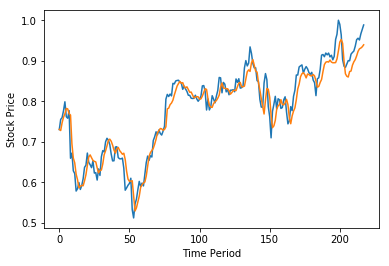

In [15]:
    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()
